# Analyse defect calculations

Now we analyse the `DefectsAnalysis` object we have created in the `import_data` notebook. This object is made from a list of `SingleDefectData` objects, which contains relevant data for every single defect. With this class we evaluate defect properties by considering every single calculation in the list. 

## Import chemical potential

To calculate defect formation energies we need chemical potentials for each defect specie. Those can be calculated beforehand or can also be retrieved from the Materials Project database. In this case we have calculated them and saved them in a `json` file. In this example we have saved the relative chemical potentials $\Delta \mu$, which means that we also need to import a dictionary with total energies for every phase calculated in the PD to reconstruct the absolute chemical potentials ($\mu = \Delta \mu + \mu_{ref}$). The chempots can also be saved directly in absolute value, with the disadvantage that the values cannot be directly compared with the ones displayed in the stability diagram. In the imported dictionary a reservoir (name) and an associated a set of chempots are defined. We use the `Chempots` and `ChempotsAnalysis` class to import and convert the chempots data. The phase diagram is constructured with the `PDHandler` class which uses `pymatgen` to construct and plot the stability diagram. 

{'A': {Element Na: -2.3152836455,
  Element Nb: -11.189198715,
  Element O: -8.32965362375},
 'B': {Element Na: -3.0852836455,
  Element Nb: -11.079198715,
  Element O: -8.109653623749999},
 'C': {Element Na: -4.665283645500001,
  Element Nb: -19.019198715,
  Element O: -4.93965362375},
 'D': {Element Na: -3.5652836455,
  Element Nb: -19.679198715,
  Element O: -4.93965362375},
 'E': {Element Na: -3.5452836455,
  Element Nb: -15.079198715,
  Element O: -6.62965362375}}

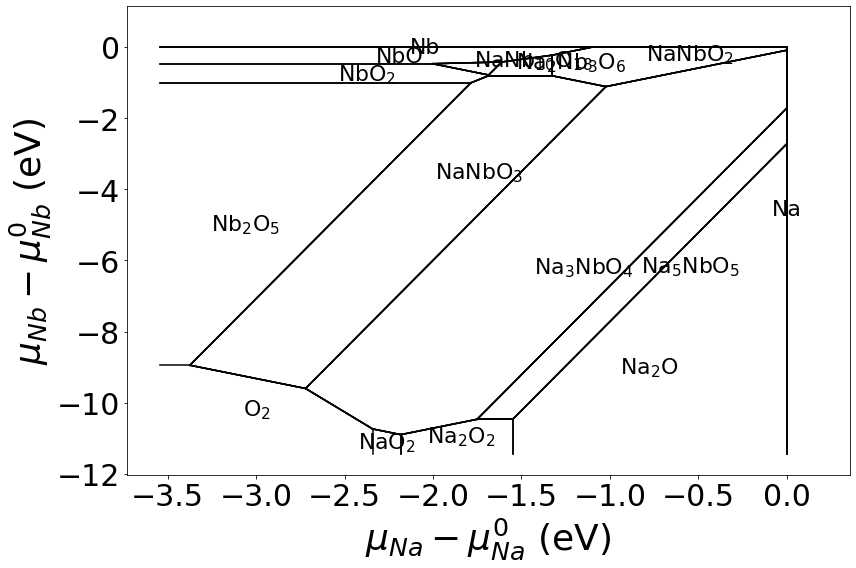

In [1]:
import json
from pynter.phase_diagram.analysis import Chempots, ChempotAnalysis, PDHandler

with open('./files/chempots_boundary_NN_R3-_PBE.json','r') as f:
    chempots = json.load(f)
with open('./files/computed_phases_NN_R3-_PBE.json') as f:
    computed_phases = json.load(f)

    
PDHandler(computed_phases).get_stability_diagram(['Na','Nb'])
chempots = {res:Chempots.from_dict(chem).chempots for res,chem in chempots.items()}
chempots = {res:ChempotAnalysis(computed_phases).get_chempots_abs(chem) for res,chem in chempots.items()}
chempots

### Create DefectAnalysis object from json file

In [2]:
from pynter.defects.analysis import DefectsAnalysis

with open('./files/defects_analysis_vacancies-PBE-R3.json') as f:
    defects_analysis = DefectsAnalysis.from_dict(json.load(f))

### Import DOS for Fermi level calculation

In [3]:
from pymatgen.electronic_structure.dos import CompleteDos

with open('./files/dos_NN_R3-_PBE.json') as f:
    bulk_dos = CompleteDos.from_dict(json.load(f))

## Calculate Fermi levels and plot data

Now that all objects are ready we can calculate the Fermi level and plot the defect formation energies for all defect species in every reservoir. The equilibrium Fermi level is calculated with the algorithm used in `pymatgen`, the non equilibrium Fermi level uses a modified algorithm that is not yet published. Both method are explained in the `methods` folder of the `notebooks` repository.

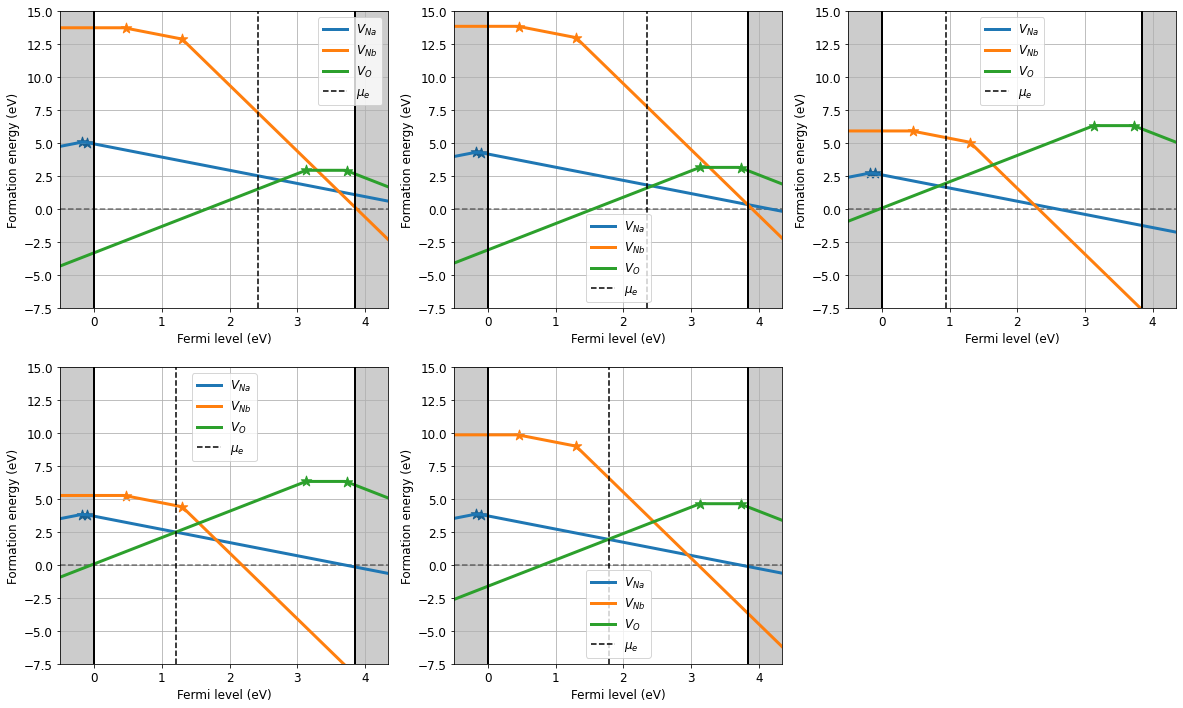

In [4]:
# index for subplots
iplot = 0
# iterate over reservoirs (and relative chempots)
for res,mu in chempots.items():
    iplot += 1
    # calculate fermi level
    fermi_level = defects_analysis.equilibrium_fermi_level(mu,bulk_dos,temperature=300)
    defects_analysis.plot(mu_elts=mu,ylim=(-7.5,15),plotsize=(2.5,2),format_legend=True,
                          fermi_level=fermi_level,get_subplot=True,subplot_settings=[2,3,iplot])   

### Plot charge transition levels

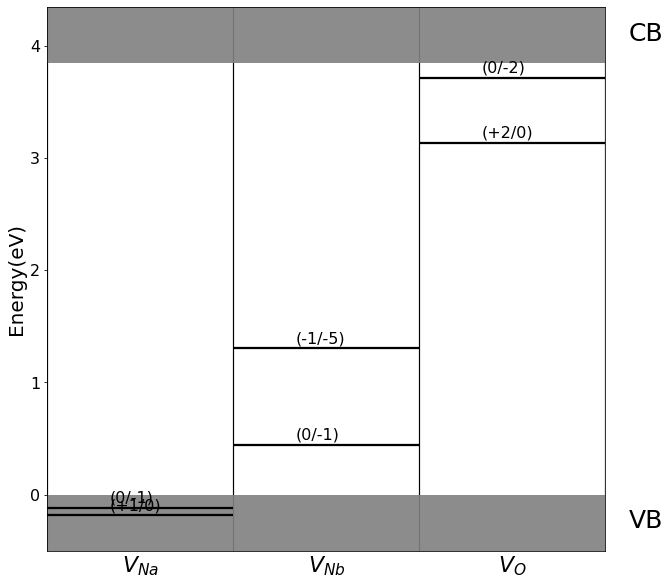

In [5]:
defects_analysis.plot_ctl();